# Project Histology Tissue Classification Project - Selection of models

## Import needed packages

In [203]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import pickle
import shutil
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

In [2]:
tf.__version__

'1.12.0'

## Loading the data

### Loading the data from pickle files

In [11]:
x_train=pickle.load(open('./data/x_train.pkl', 'rb'))
x_test=pickle.load(open('./data/x_test.pkl', 'rb'))
x_val=pickle.load(open('./data/x_val.pkl', 'rb'))

In [12]:
y_train=pickle.load(open('./data/y_train.pkl', 'rb'))
y_test=pickle.load(open('./data/y_test.pkl', 'rb'))
y_val=pickle.load(open('./data/y_val.pkl', 'rb'))

### Basics checks

In [13]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


In [14]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

In [15]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(1.0, 1.0, 1.0)

## Building models

### Defining the input shape

In [18]:
(x_train.shape[1],x_train.shape[2],x_train.shape[3])

(150, 150, 3)

In [19]:
input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])

In [20]:
input_shape

(150, 150, 3)

### Define plot style

In [31]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [34]:
plt.style.use('seaborn-ticks')

In [161]:
def plot_acc_loss(history):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epoch ")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epoch ")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="best");
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['acc'][-1]))
    print('  - accuracy [validation dataset: {:.2f}%'.format(100*history.history['val_acc'][-1]))

### CNN model v1

In [221]:
def model_cnn_v1():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 3, 3, input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    #model.add(tf.keras.layers.Conv2D(32, 3, 3))
    #model.add(tf.keras.layers.Activation('relu'))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, 3, 3))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Activation('sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v1=model_cnn_v1()

# take a look at the model summary
model_cnn_v1.summary()

# save weight before training
initial_weights = model_cnn_v1.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
__________

In [220]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v1.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=100
BATCH_SIZE=256
#BATCH_SIZE=128
#BATCH_SIZE=64

history=model_cnn_v1.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/100
2816/3000 [===========================>..] - ETA: 0s - loss: 2.0357 - acc: 0.1772
Epoch 00001: val_loss improved from inf to 1.92090, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 20s 7ms/step - loss: 2.0298 - acc: 0.1817 - val_loss: 1.9209 - val_acc: 0.3640
Epoch 2/100
2816/3000 [===========================>..] - ETA: 0s - loss: 1.8440 - acc: 0.2688
Epoch 00002: val_loss improved from 1.92090 to 1.69111, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 7s 2ms/step - loss: 1.8381 - acc: 0.2697 - val_loss: 1.6911 - val_acc: 0.3690
Epoch 3/100
2816/3000 [===========================>..] - ETA: 0s - loss: 1.7066 - acc: 0.2873
Epoch 00003: val_loss improved from 1.69111 to 1.60795, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 6s 2ms/step - loss: 1.6998 - acc: 0.2877 - 

Epoch 27/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.9240 - acc: 0.5419
Epoch 00027: val_loss improved from 0.84819 to 0.84573, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 6s 2ms/step - loss: 0.9242 - acc: 0.5453 - val_loss: 0.8457 - val_acc: 0.5540
Epoch 28/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.9216 - acc: 0.5479
Epoch 00028: val_loss improved from 0.84573 to 0.83846, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9199 - acc: 0.5507 - val_loss: 0.8385 - val_acc: 0.5570
Epoch 29/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.9242 - acc: 0.5476
Epoch 00029: val_loss improved from 0.83846 to 0.83020, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.9201 - acc: 0.5470 - val_loss: 0.8302 - val_acc: 0.5810
Epoch 3

Epoch 55/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.7103 - acc: 0.6609
Epoch 00055: val_loss did not improve from 0.68849
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7089 - acc: 0.6620 - val_loss: 0.6887 - val_acc: 0.6650
Epoch 56/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6986 - acc: 0.6669
Epoch 00056: val_loss did not improve from 0.68849
3000/3000 [==============================] - 6s 2ms/step - loss: 0.7006 - acc: 0.6657 - val_loss: 0.6966 - val_acc: 0.6710
Epoch 57/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.7068 - acc: 0.6587
Epoch 00057: val_loss improved from 0.68849 to 0.68450, saving model to ./results/model_cnn_v1.weights.best.hdf5
3000/3000 [==============================] - 5s 2ms/step - loss: 0.7021 - acc: 0.6620 - val_loss: 0.6845 - val_acc: 0.6730
Epoch 58/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6959 - acc: 0.6584
Epoch 00058: val_loss improved from 

Epoch 85/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6085 - acc: 0.6985
Epoch 00085: val_loss did not improve from 0.66071
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6094 - acc: 0.6977 - val_loss: 0.6649 - val_acc: 0.6720
Epoch 86/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6447 - acc: 0.6889
Epoch 00086: val_loss did not improve from 0.66071
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6559 - acc: 0.6887 - val_loss: 0.7398 - val_acc: 0.6700
Epoch 87/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6641 - acc: 0.6719
Epoch 00087: val_loss did not improve from 0.66071
3000/3000 [==============================] - 5s 2ms/step - loss: 0.6572 - acc: 0.6760 - val_loss: 0.6940 - val_acc: 0.6590
Epoch 88/100
2816/3000 [===========================>..] - ETA: 0s - loss: 0.6131 - acc: 0.6850
Epoch 00088: val_loss did not improve from 0.66071
3000/3000 [==============================] - 5s

Loss:
  - loss [training dataset]: 0.541
  - loss [validation dataset: 0.610

Accuracy:
  - accuracy [training dataset]: 78.23%
  - accuracy [validation dataset: 76.60%


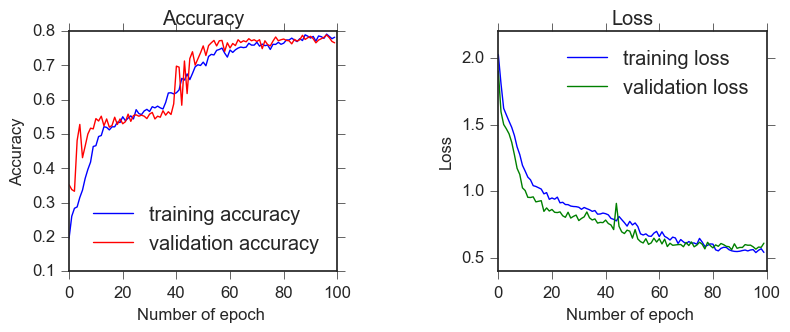

In [176]:
plot_acc_loss(history)

### CNN model v2

In [215]:
def model_cnn_v2():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256,activation = "relu"))          
    model.add(tf.keras.layers.Dense(64,activation = "relu"))
    model.add(tf.keras.layers.Dense(32,activation = "relu"))

    model.add(tf.keras.layers.Dense(8, activation = "softmax"))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v2=model_cnn_v2()

# take a look at the model summary
model_cnn_v2.summary()

# save weight before training
initial_weights = model_cnn_v2.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
__________

In [183]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v2.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v2.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
#BATCH_SIZE=256
#BATCH_SIZE=128
BATCH_SIZE=64

history=model_cnn_v2.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
2944/3000 [============================>.] - ETA: 6s - loss: 1.7105 - acc: 0.2812 
Epoch 00001: val_loss improved from inf to 1.60882, saving model to ./results/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 383s 128ms/step - loss: 1.6989 - acc: 0.2833 - val_loss: 1.6088 - val_acc: 0.3690
Epoch 2/50
2944/3000 [============================>.] - ETA: 6s - loss: 1.1224 - acc: 0.4786 
Epoch 00002: val_loss improved from 1.60882 to 0.93550, saving model to ./results/model_cnn_v2.weights.best.hdf5
3000/3000 [==============================] - 380s 127ms/step - loss: 1.1177 - acc: 0.4817 - val_loss: 0.9355 - val_acc: 0.5940
Epoch 3/50
2944/3000 [============================>.] - ETA: 6s - loss: 0.9435 - acc: 0.5730 
Epoch 00003: val_loss did not improve from 0.93550
3000/3000 [==============================] - 377s 126ms/step - loss: 0.9406 - acc: 0.5750 - val_loss: 0.9471 - val_acc: 0.5950
Epoch 4/50
2944/

Epoch 30/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0902 - acc: 0.9708 
Epoch 00030: val_loss did not improve from 0.62846
3000/3000 [==============================] - 338s 113ms/step - loss: 0.0887 - acc: 0.9713 - val_loss: 1.1311 - val_acc: 0.7690
Epoch 31/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0495 - acc: 0.9830 
Epoch 00031: val_loss did not improve from 0.62846
3000/3000 [==============================] - 336s 112ms/step - loss: 0.0488 - acc: 0.9833 - val_loss: 1.1020 - val_acc: 0.7720
Epoch 32/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0683 - acc: 0.9786 
Epoch 00032: val_loss did not improve from 0.62846
3000/3000 [==============================] - 336s 112ms/step - loss: 0.0677 - acc: 0.9787 - val_loss: 1.1498 - val_acc: 0.7790
Epoch 33/50
2944/3000 [============================>.] - ETA: 5s - loss: 0.0762 - acc: 0.9738 
Epoch 00033: val_loss did not improve from 0.62846
3000/3000 [========================

Loss:
  - loss [training dataset]: 0.046
  - loss [validation dataset: 0.951

Accuracy:
  - accuracy [training dataset]: 98.87%
  - accuracy [validation dataset: 78.70%


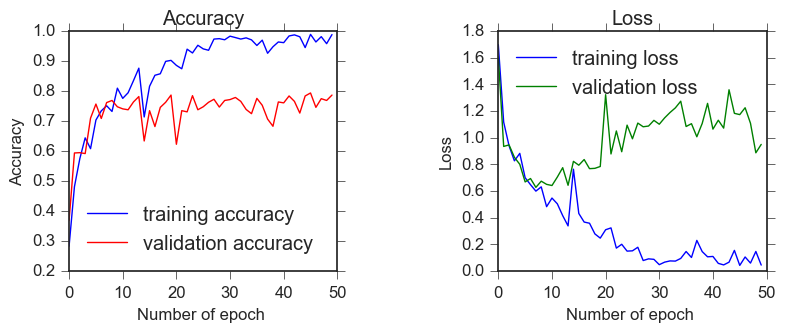

In [184]:
plot_acc_loss(history)

### CNN model v3

In [185]:
def model_cnn_v3():
    
    # must define the input shape in the first layer of the neural network
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')) 
    model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3)) 

    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))

    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size = 3))
    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.Dense(8, activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_cnn_v3=model_cnn_v3()

# take a look at the model summary
model_cnn_v3.summary()

# save weight before training
initial_weights = model_cnn_v3.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        9248      
__________

In [187]:
%%time
# set to the original weights for testing other pipelines
model_cnn_v3.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v3.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=50
#BATCH_SIZE=256
#BATCH_SIZE=128
BATCH_SIZE=64

history=model_cnn_v3.fit(x_train,
                         y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(x_test, y_test),
                         callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
2944/3000 [============================>.] - ETA: 2s - loss: 1.6463 - acc: 0.2833
Epoch 00001: val_loss improved from inf to 1.69766, saving model to ./results/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 144s 48ms/step - loss: 1.6401 - acc: 0.2840 - val_loss: 1.6977 - val_acc: 0.3070
Epoch 2/50
2944/3000 [============================>.] - ETA: 2s - loss: 1.2633 - acc: 0.4079
Epoch 00002: val_loss improved from 1.69766 to 1.55507, saving model to ./results/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 118s 39ms/step - loss: 1.2652 - acc: 0.4077 - val_loss: 1.5551 - val_acc: 0.2830
Epoch 3/50
2944/3000 [============================>.] - ETA: 2s - loss: 1.1490 - acc: 0.4494
Epoch 00003: val_loss improved from 1.55507 to 1.30854, saving model to ./results/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 117s 39ms/step - loss: 1.1478 - acc: 0.45

Epoch 29/50
2944/3000 [============================>.] - ETA: 1s - loss: 0.2848 - acc: 0.8971
Epoch 00029: val_loss did not improve from 0.58502
3000/3000 [==============================] - 114s 38ms/step - loss: 0.2852 - acc: 0.8967 - val_loss: 1.3567 - val_acc: 0.5830
Epoch 30/50
2944/3000 [============================>.] - ETA: 1s - loss: 0.2405 - acc: 0.9168
Epoch 00030: val_loss did not improve from 0.58502
3000/3000 [==============================] - 114s 38ms/step - loss: 0.2416 - acc: 0.9153 - val_loss: 0.6695 - val_acc: 0.7730
Epoch 31/50
2944/3000 [============================>.] - ETA: 1s - loss: 0.2038 - acc: 0.9273
Epoch 00031: val_loss improved from 0.58502 to 0.56030, saving model to ./results/model_cnn_v3.weights.best.hdf5
3000/3000 [==============================] - 114s 38ms/step - loss: 0.2038 - acc: 0.9270 - val_loss: 0.5603 - val_acc: 0.8050
Epoch 32/50
2944/3000 [============================>.] - ETA: 1s - loss: 0.2166 - acc: 0.9161
Epoch 00032: val_loss did not i

Loss:
  - loss [training dataset]: 0.132
  - loss [validation dataset: 0.633

Accuracy:
  - accuracy [training dataset]: 95.90%
  - accuracy [validation dataset: 79.00%
CPU times: user 33.9 ms, sys: 8.61 ms, total: 42.5 ms
Wall time: 45 ms


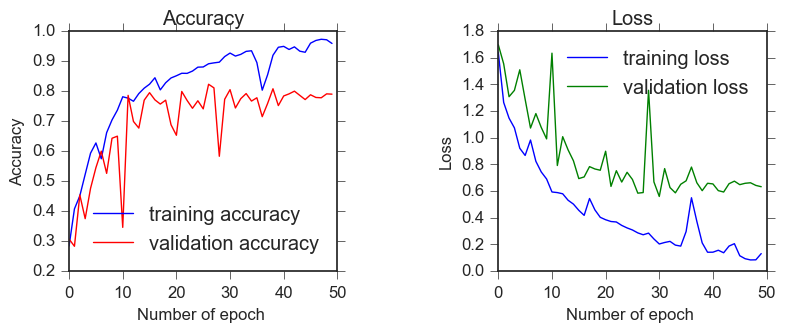

In [189]:
plot_acc_loss(history)

### VGG16 model v4 and retraining if of the last 4 layers

In [198]:
def model_vgg16_v4():
    
    # load the VGG model
    vgg_conv = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
    
    # freeze the layers except the last 4 layers
    for layer in vgg_conv.layers[:-4]:
        layer.trainable = False
 
    # Check the trainable status of the individual layers
    for layer in vgg_conv.layers:
        print(layer, layer.trainable)
        
    # create the model
    model = tf.keras.models.Sequential()
 
    # add the vgg convolutional base model
    model.add(vgg_conv)
 
    # add new layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(8, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

# reset the model
tf.keras.backend.clear_session()

# create the model
model_vgg16_v4=model_vgg16_v4()

# take a look at the model summary
model_vgg16_v4.summary()

# save weight before training
initial_weights = model_vgg16_v4.get_weights()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x1cafdf198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cafdf630> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cafdf390> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1cafece10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cafdfe80> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cb10a780> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1cb126ef0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cb14bf60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cb166b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cb1ae6d8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1cb1e6b70> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1cb1caa90> False
<tensorflow.py

In [199]:
%%time
# set to the original weights for testing other pipelines
model_vgg16_v4.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_vgg16_v4.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=30
#BATCH_SIZE=256
BATCH_SIZE=128
#BATCH_SIZE=64

history=model_vgg16_v4.fit(x_train,
                           y_train,
                           batch_size=BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=(x_test, y_test),
                           callbacks=[checkpointer])

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
2944/3000 [============================>.] - ETA: 12s - loss: 2.0486 - acc: 0.3662
Epoch 00001: val_loss improved from inf to 1.27946, saving model to ./results/model_vgg16_v4.weights.best.hdf5
3000/3000 [==============================] - 865s 288ms/step - loss: 2.0349 - acc: 0.3687 - val_loss: 1.2795 - val_acc: 0.5090
Epoch 2/30
2944/3000 [============================>.] - ETA: 11s - loss: 1.2152 - acc: 0.4898
Epoch 00002: val_loss improved from 1.27946 to 1.00935, saving model to ./results/model_vgg16_v4.weights.best.hdf5
3000/3000 [==============================] - 820s 273ms/step - loss: 1.2121 - acc: 0.4897 - val_loss: 1.0094 - val_acc: 0.5760
Epoch 3/30
2944/3000 [============================>.] - ETA: 11s - loss: 0.9811 - acc: 0.5815
Epoch 00003: val_loss improved from 1.00935 to 0.81545, saving model to ./results/model_vgg16_v4.weights.best.hdf5
3000/3000 [==============================] - 818s 273ms/step - loss: 0.9788

Epoch 29/30
2944/3000 [============================>.] - ETA: 11s - loss: 0.0068 - acc: 0.9990
Epoch 00029: val_loss did not improve from 0.36182
3000/3000 [==============================] - 773s 258ms/step - loss: 0.0067 - acc: 0.9990 - val_loss: 0.6518 - val_acc: 0.9010
Epoch 30/30
2944/3000 [============================>.] - ETA: 11s - loss: 0.0055 - acc: 0.9990
Epoch 00030: val_loss did not improve from 0.36182
3000/3000 [==============================] - 773s 258ms/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.6236 - val_acc: 0.9010
CPU times: user 7h 4min 55s, sys: 2min 6s, total: 7h 7min 1s
Wall time: 6h 31min 3s


Loss:
  - loss [training dataset]: 0.005
  - loss [validation dataset: 0.624

Accuracy:
  - accuracy [training dataset]: 99.90%
  - accuracy [validation dataset: 90.10%


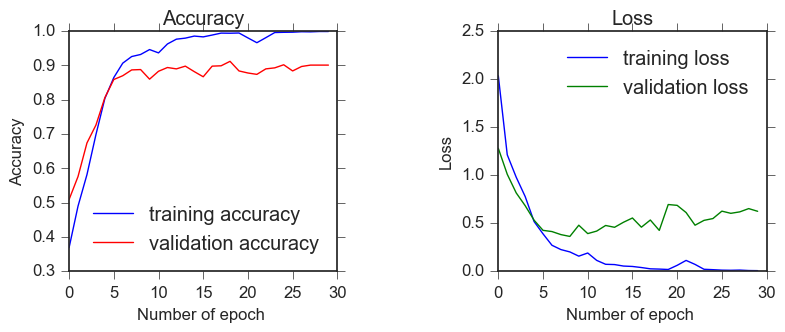

In [200]:
plot_acc_loss(history)

### CNN model v1 with data augmentation

In [210]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             fill_mode="nearest")

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and 
- height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [211]:
datagen.fit(x_train)

In [ ]:
%%time

# set to the original weights for testing other pipelines
model_cnn_v1.set_weights(initial_weights)

# define path to save the mnodel
path_model='./results/model_cnn_v1_aug.weights.best.hdf5'
shutil.rmtree(path_model, ignore_errors=True)

checkpointer = ModelCheckpoint(filepath=path_model, 
                               verbose = 1, 
                               save_best_only=True)
EPOCHS=100
BATCH_SIZE=256
#BATCH_SIZE=128
#BATCH_SIZE=64


history=model_cnn_v1.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                                   validation_data=(x_test, y_test),
                                   #steps_per_epoch=len(x_trainX) // BS,
                                   epochs=EPOCHS, 
                                   callbacks=[checkpointer])

Epoch 1/100
11/12 [==========================>...] - ETA: 1s - loss: 2.0142 - acc: 0.2050
Epoch 00001: val_loss improved from inf to 1.84514, saving model to ./results/model_cnn_v1_aug.weights.best.hdf5
12/12 [==============================] - 16s 1s/step - loss: 2.0046 - acc: 0.2115 - val_loss: 1.8451 - val_acc: 0.2740
Epoch 2/100
11/12 [==========================>...] - ETA: 1s - loss: 1.7705 - acc: 0.2651
Epoch 00002: val_loss improved from 1.84514 to 1.54059, saving model to ./results/model_cnn_v1_aug.weights.best.hdf5
12/12 [==============================] - 15s 1s/step - loss: 1.7660 - acc: 0.2657 - val_loss: 1.5406 - val_acc: 0.3110
Epoch 3/100
11/12 [==========================>...] - ETA: 1s - loss: 1.5954 - acc: 0.3066
Epoch 00003: val_loss improved from 1.54059 to 1.38486, saving model to ./results/model_cnn_v1_aug.weights.best.hdf5
12/12 [==============================] - 15s 1s/step - loss: 1.5852 - acc: 0.3084 - val_loss: 1.3849 - val_acc: 0.3270
Epoch 4/100
11/12 [=======

In [ ]:
plot_acc_loss(history)